# Sailors

### Requirements

In [6]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## I. Mousse_2

### Defining Agent

In [20]:
class Mousse_2(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()

        self.learning_rate = learning_rate
        self.adapt = 0.01
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

        self.position_bins = 32     # Discretize the grid into 32 x 32
        self.veloc_angle_bins = 16     # Discretize velocity into 4 bins
        self.win_angle_bins = 16         # Discretize wind directions into 8 bins

        self.q_table = {}

        self.complexity = self.position_bins * self.position_bins * self.veloc_angle_bins * self.win_angle_bins
        
        self.q_visit = {}
        self.ite_learned = 0
        self.training_session = 0
        self.restart_training = False

        self.hist_pos = []
        self.hist_veloc = []
        self.hist_wind = []


    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        

        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_ang = 0
            v_mag = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_ang = int(((v_direction + np.pi) / (2 * np.pi) * (self.veloc_angle_bins-1)) + 1) % self.veloc_angle_bins
            v_mag = int(v_magnitude)
        
        # Discretize wind direction
        def wind_transf(wx, wy):
            wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
            wind_ang = int(((wind_direction + np.pi) / (2 * np.pi) * self.win_angle_bins)) % self.win_angle_bins
            wind_mag = int(np.sqrt(wx**2 + wy**2))
            return wind_ang, wind_mag

        wind_ang, wind_mag = wind_transf(wx,wy)

        """
        Still in work for adding wind conditions from other position of interest


        t1 = (x_bin, y_bin, v_ang, v_mag, wind_ang, wind_mag)

        for i in range(grid_size):
            line = i * 32
            j = max(i, (3/4) * 32 / 2)
            for k in range(j):
                wxt, wyt = observation[6 + line + 15 - j]
                wxp, wyp = observation[6 + line + 16 + j]
                wa_t,wa_m = wind_transf(wxt, wyt)
                wa_p, wm_p = wind_transf(wxp, wyp)
        """

        # Return discrete state tuple
        return (x_bin, y_bin, v_ang, v_mag, wind_ang, wind_mag)
    
        
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        self.hist_pos.append((state[0], state[1]))
        self.hist_veloc.append((state[2], state[3]))
        self.hist_wind.append((state[4],state[5]))
        
        # Epsilon-greedy action selection
        if self.np_random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.np_random.integers(0, 9)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
            
            # Return action with highest Q-value
            return np.argmax(self.q_table[state])
        

    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        self.ite_learned += 1

        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
            
        if state not in self.q_visit:    
            self.q_visit[state] = 0
        else:
            self.q_visit[state] += 1

        # use of adaptive learning_rate
        adapt_learning_rate = self.learning_rate / (1 + self.adapt*self.q_visit[state])

        # use of exploration bonus
        exploration_bonus = 1 / (1 + np.sqrt(self.q_visit[state]))
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action] + exploration_bonus # modified
        self.q_table[state][action] += adapt_learning_rate * td_error   # modified
    
    def reset(self) -> None:
        """Reset the agent."""
        self.q_table.clear()
        self.ite_learned = 0
        self.training_session = 0
    
    def set_hist(self) -> None:
        """Reset only history variables"""
        self.hist_pos.clear()
        self.hist_veloc.clear()
        self.hist_wind.clear()


    def seed(self, seed: int = None) -> dict:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

    def quick_test(self, num_test, max_steps):
        """Simple testing method during training to show improvements of results without exploration"""
        # Turn off exploration for evaluation
        self.exploration_rate = 0

        print("------ BEGINNING TEST -------------------------------                                ")

        # Create test environment
        dico_env = {}
        dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
        dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
        dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

        i = np.random.randint(1, 4)
        test_env = dico_env[i]

        print("Testing the trained agent on 5 new episodes...")
        # Testing loop
        
        results_steps = []
        results_rew = []
        results_avg_speed = []

        for episode in range(num_test):
            # Reset environment
            observation, info = test_env.reset(seed=100000 + episode)  # Different seeds from training
            self.set_hist()
            
            total_reward = 0
            
            for step in range(max_steps):
                # Select action using learned policy
                action = self.act(observation)
                observation, reward, done, truncated, info = test_env.step(action)
                
                total_reward += reward*np.power(self.discount_factor, step)
                
                # Break if episode is done
                if done or truncated:
                    results_steps.append(step)
                    results_rew.append(total_reward)
                    results_avg_speed.append(np.mean(self.hist_veloc[:1]))
                    break
            
            if not(done or truncated):
                results_steps.append(step)
                results_rew.append(total_reward)

        med_s = np.median(results_steps)
        q10_s = np.quantile(results_steps, 0.1)
        q90_s = np.quantile(results_steps, 0.9)

        med_r = np.median(results_rew)
        q10_r = np.quantile(results_rew, 0.9)
        q90_r = np.quantile(results_rew, 0.1)

        med_a = np.median(results_avg_speed)
        q10_a = np.quantile(results_avg_speed, 0.1)
        q90_a = np.quantile(results_avg_speed, 0.9)
            
        print(
            f"For {num_test} tests : \n" +
            "----------------------------------------------------- \n"
            f"Steps   | med = {round(med_s,1)} | [{round(q10_s,1)} | {round(q90_s,1)}] \n"+
            f"Rewards | med = {round(med_r,1)} | [{round(q10_r,1)} | {round(q90_r,1)}] \n" + 
            f"Speed   | med = {round(med_a,1)} | [{round(q10_a,1)} | {round(q90_a,1)}] \n"
            "----------------------------------------------------- \n" +
            "------ ENDING TEST ----------------------------------"
            )

    def show_visited_state(self, interpol = "nearest", show = True):
        matrice = np.zeros((self.position_bins, self.position_bins))

        for key in self.q_visit.keys():
            x, y, v_ang, v_mag, w_ang, w_mag = key
            matrice[y][x] += self.q_visit[key] / self.training_session

        if show == True:
            matrice = np.log(matrice + 1)
            plt.figure(figsize=(6, 6))
            plt.imshow(matrice, cmap='Blues', interpolation=interpol)
            plt.colorbar()
            plt.gca().invert_yaxis()  # Inversion de l'axe Y
            plt.show()
        else:
            return matrice

        

### Training

In [21]:
sailor = Mousse_2(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

np.random.seed(42)
sailor.seed(42)

sailor.restart_training = True

Starting full training with 60000 episodes...
------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 45.5 | [34.0 | 159.9] 
Rewards | med = 63.3 | [71.1 | 20.1] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------


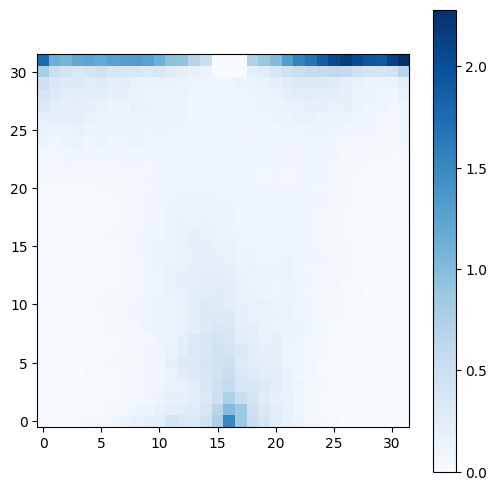

------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 92.0 | [74.7 | 499.0] 
Rewards | med = 39.7 | [47.2 | 0.0] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------
------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 133.0 | [106.8 | 370.3] 
Rewards | med = 26.3 | [34.2 | 2.5] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------


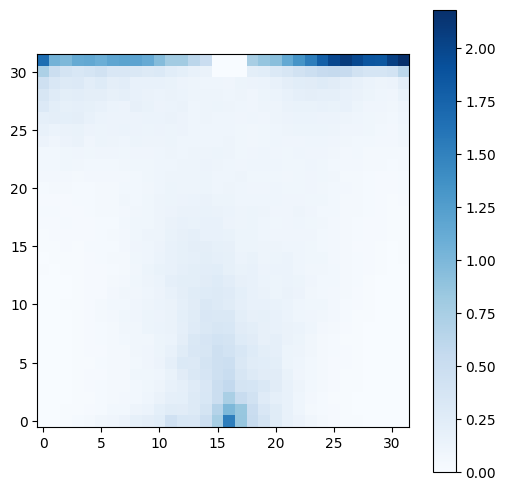

------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 41.5 | [30.9 | 60.2] 
Rewards | med = 65.9 | [73.3 | 54.6] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------


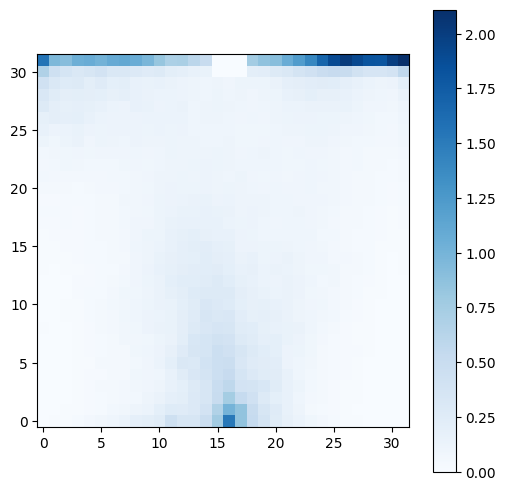

------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 87.0 | [72.9 | 114.0] 
Rewards | med = 41.7 | [48.1 | 31.8] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------
------ BEGINNING TEST -------------------------------                                     
Testing the trained agent on 5 new episodes...
For 100 tests : 
----------------------------------------------------- 
Steps   | med = 87.0 | [72.9 | 113.1] 
Rewards | med = 41.7 | [48.1 | 32.1] 
Speed   | med = 0.0 | [0.0 | 0.0] 
----------------------------------------------------- 
------ ENDING TEST ----------------------------------


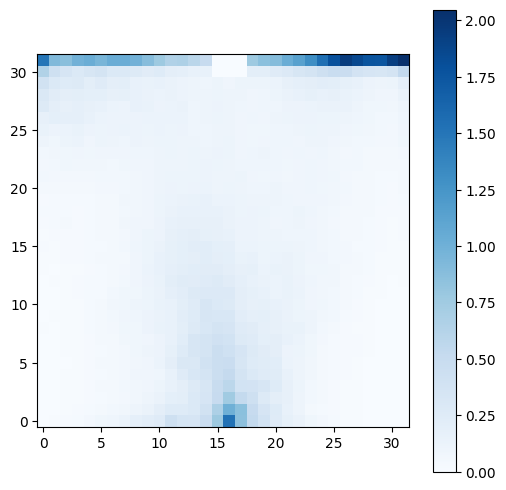


Training completed in 1333.5 seconds!
Success rate: 100.0%
Average reward: 98.94
Average steps: 214.3
Q-table size: 425942 states


In [23]:
exploration_rate = 0.3
# Training parametersx
sailor.exploration_rate = exploration_rate

num_episodes = 60000  # Small number for debugging
max_steps = 1000    

batch = 100
batch_test = 10000
batch_mat = 15000


if sailor.restart_training == True:
# This line reinitializes q table
    sailor.reset()
    sailor.restart_training = False


# Create environment with a simple initial windfield
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))
    
# Progress tracking
rewards_history = []
steps_history = []
success_history = []
true_rew = []

# Training loop
print(f"Starting full training with {num_episodes} episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    i = np.random.randint(1, 4)
    env = dico_env[i]
    # Reset environment and get initial state
    sailor.set_hist()
    sailor.training_session += 1

    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = sailor.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)
        
        # Update Q-table
        sailor.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    true_rew.append(np.power(sailor.discount_factor,step)*total_reward)

    # Update exploration rate (decrease over time)
    # Done in the learning fonction
    
    # Print progress every 10 episodes

    # Plot progress

    if (episode + 1) % batch == 0:
        step_avg = sum(steps_history[-batch:]) / batch
        print(f"Episode {episode+1}/{num_episodes}: session {sailor.training_session} -  Steps avg: {step_avg} - " +
               f"- q size: {len(sailor.q_table)}"+
               f" ({round(len(sailor.q_table)/sailor.complexity,2)})         ", end="\r")
        
    if (episode + 1) % batch_test == 0:
        sailor.quick_test(num_test=100, max_steps=500)
        sailor.exploration_rate = exploration_rate

    if (episode+1) % batch_mat == 0:
        sailor.show_visited_state()
        
training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(sailor.q_table)} states")

### Training Performance

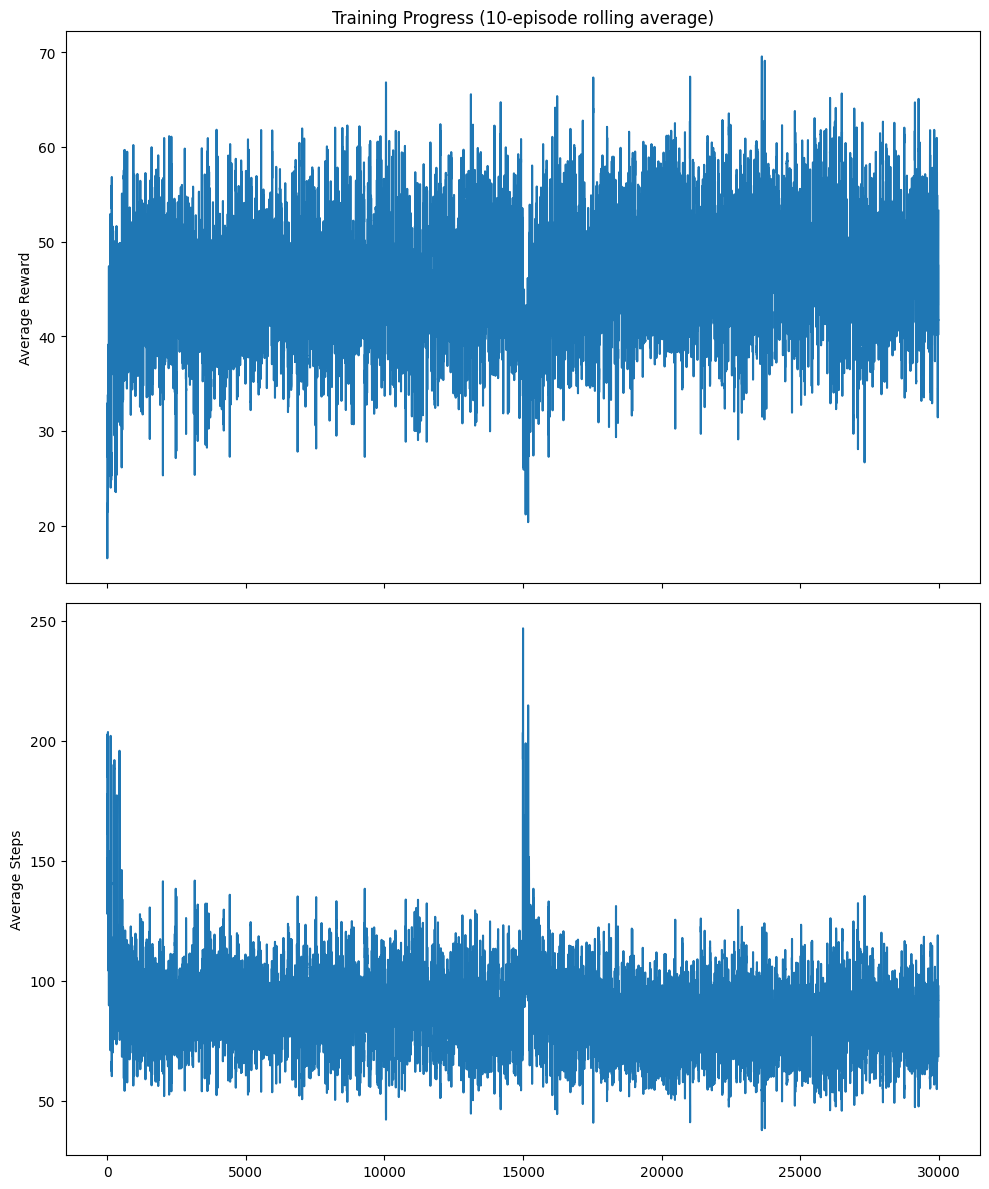

In [22]:
import matplotlib.pyplot as plt

# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(true_rew, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

### Testing

In [ ]:


    # Turn off exploration for evaluation
    sailor.exploration_rate = 0

    # Create test environment
    dico_env = {}
    dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
    dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
    dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

    i = np.random.randint(1, 4)
    test_env = dico_env[i]

    print("Testing the trained agent on 5 new episodes...")
    # Testing loop
    
    results_steps = []
    results_rew = []

    for episode in range(num_test):
        # Reset environment
        observation, info = test_env.reset(seed=100000 + episode)  # Different seeds from training
        sailor.set_hist()
        
        total_reward = 0
        
        for step in range(max_steps):
            # Select action using learned policy
            action = sailor.act(observation)
            observation, reward, done, truncated, info = test_env.step(action)
            
            total_reward += reward*np.power(sailor.discount_factor, step)
            
            # Break if episode is done
            if done or truncated:
                results_steps.append(step)
                results_rew.append(total_reward)
                break
        
        if not(done or truncated):
            results_steps.append(step)
            results_rew.append(total_reward)

    med_s = np.median(results_steps)
    q10_s = np.quantile(results_steps, 0.1)
    q90_s = np.quantile(results_steps, 0.9)

    med_r = np.median(results_rew)
    q10_r = np.quantile(results_rew, 0.1)
    q90_r = np.quantile(results_rew, 0.9)
        
    print(
        f"for {num_test} tests : \n" +
        f"Steps : med = {med_s} - q10 = {q10_s}, - q90 = {q90_s} \n"+
        f"Rewards : med = {med_r} - q10 = {q10_r}, - q90 = {q90_r}"
          )

### Saving Agent

In [24]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sailor,
    output_path="agents/mousse_2.py",
    agent_class_name="Mousse_2"
)

Agent saved to agents/mousse_2.py
The file contains 425942 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb
